In [99]:
from data_loader import train, test
from preprocessing import *
from clickfeatures import regularity, procrastination
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [44]:
def build_timebased_regularity(studentVle, assessments):
    # define helper functions
    def extract_timestamps_and_weights(df):
        return pd.Series({
            'timestamps': df['date'].tolist(),
            'weights': df['sum_click'].tolist()})
    
    def extract_test_dates(df, num_dates=3):
        return pd.Series({'dates': sorted(df['date'].tolist())[:num_dates]})
    
    def get_time_regularity(df, using_testing_dates=0, user_defined_range=[]):
        if user_defined_range:
            start, end = user_defined_range
        elif 0 <= using_testing_dates <= 2:
            start = 0
            end = df['dates'][using_testing_dates]

        ts = df['timestamps']
        ws = df['weights']
        # cut off dates after the end date
        ts = filter(lambda x: x <= end, ts)
        ws = ws[:len(ts)]
        r = regularity.TimeRegularity(ts, ws, end=end, unit='day')
        return r.get_regularity()

    def unwrap_time_regularity(df, metrics=['pwd', 'ws1', 'ws2', 'ws3', 'fwd']):
        assert 'regularity' in df.columns
        for metric in metrics:
            df[metric] = df['regularity'].apply(
                lambda x: x[metric] if metric in x else np.nan)
        return df

    # make a copy
    studentVle = studentVle.copy()
    assessments = assessments.copy()
    
    #######################
    # preprocess studentVle
    #######################
    studentVle = studentVle.query('date >= 0')

    # aggregate daily clicks
    identifiers = ['code_module', 'code_presentation', 'id_student', 'date']
    studentVle = studentVle.groupby(identifiers)['sum_click'].agg('sum').reset_index()
    studentVle.sort_values(identifiers, inplace=True)
    
    # apply function
    identifiers = ['code_module', 'code_presentation', 'id_student']
    studentVle = studentVle.groupby(identifiers).apply(extract_timestamps_and_weights)
    studentVle.reset_index(inplace=True)
    
    #######################
    # preprocess assessments
    #######################
    identifiers = ['code_module', 'code_presentation']
    assessments = assessments.groupby(identifiers).apply(extract_test_dates)
    assessments.reset_index(inplace=True)
    
    # merge
    identifiers = ['code_module', 'code_presentation']
    studentVle = studentVle.merge(assessments, on=identifiers, how='left')
    
    # build features
    studentVle['regularity'] = studentVle.apply(get_time_regularity, axis=1)
    studentVle = unwrap_time_regularity(studentVle)
    
    # drop unuseful columns
    studentVle.drop(['regularity', 'timestamps', 'weights', 'dates'], axis=1, inplace=True)

    return studentVle

In [15]:
def build_activitybased_regularity(studentVle, vle, drop_columns=True):

    valid_activies = [
        'forumng', 'subpage', 'oucontent', 'homepage', 'quiz', 
        'resource', 'url', 'ouwiki', 'externalquiz', 'page',
        'oucollaborate', 'questionnaire', 'ouelluminate',
        'glossary', 'dualpane', 'dataplus', 'folder',
        'sharedsubpage', 'repeatactivity']
    
    def extract_activities(df):
        return dict(zip(df['activity_type'], df['sum_click']))

    def agg_activities(df, valid_activies=valid_activies):
        df = df.copy()
        df.sort_values('date', inplace=True)
        res = []
        for index in df.index:
            row = []
            for activity in valid_activies:
                try:
                    row.append(df.at[index, 'activities'][activity])
                except KeyError:
                    row.append(0)
            res.append(row)
        return pd.Series({'activities': res})

    def get_activity_regularity(activities, activity_names=valid_activies):
        r = regularity.ActivityRegularity(activity_names, activities)
        return r.get_regularity()
    
    def unwrap_activity_regularity(df, metrics=['concentration', 'consistency']):
        assert 'regularity' in df.columns
        for metric in metrics:
            df[metric] = df['regularity'].apply(
                lambda x: x[metric] if metric in x else np.nan)
        return df

    # make a copy
    vle = vle.copy()
    studentVle = studentVle.copy()
    
    #######################
    # preprocess
    #######################
    identifiers = ['code_module', 'code_presentation', 'id_site']
    studentVle = studentVle.query('date >= 0')
    studentVle = studentVle.merge(vle, on=identifiers, how='inner')
    
    # aggregate clicks
    identifiers = ['code_module', 'code_presentation', 'id_student', 'date', 'activity_type']
    studentVle = studentVle.groupby(identifiers)['sum_click'].agg('sum').reset_index()
    
    # build features
    identifiers = ['code_module', 'code_presentation', 'id_student', 'date']
    studentVle = studentVle.groupby(identifiers).apply(extract_activities).reset_index()
    studentVle.columns = identifiers + ['activities']
    
    identifiers = ['code_module', 'code_presentation', 'id_student']
    studentVle = studentVle.groupby(identifiers).apply(agg_activities).reset_index()
    
    studentVle['regularity'] = studentVle['activities'].apply(get_activity_regularity)
    studentVle = unwrap_activity_regularity(studentVle)
    
    # drop useless columns
    if drop_columns:
        studentVle.drop(['regularity', 'activities'], axis=1, inplace=True)
    
    return studentVle

In [104]:
def build_procrastination(studentVle, assessments):
    # define helper functions
    def extract_timestamps_and_weights(df):
        return pd.Series({
            'timestamps': df['date'].tolist(),
            'weights': df['sum_click'].tolist()})
    
    def extract_test_dates(df, num_dates=3):
        return pd.Series({'dates': sorted(df['date'].tolist())[:num_dates]})
    
    def get_procastination(df, fun, using_testing_dates=0, user_defined_range=[]):
        if user_defined_range:
            start, end = user_defined_range
        elif 0 <= using_testing_dates <= 2:
            start = 0
            end = df['dates'][using_testing_dates]

        ts = df['timestamps']
        ws = df['weights']
        # cut off dates after the end date
        ts = filter(lambda x: x <= end, ts)
        ws = ws[:len(ts)]
        p = procrastination.WeightedMean(fun, ts, ws, end=end, unit='day')
        return p.get_procrastination()

    # make a copy
    studentVle = studentVle.copy()
    assessments = assessments.copy()
    
    #######################
    # preprocess studentVle
    #######################
    studentVle = studentVle.query('date >= 0')

    # aggregate daily clicks
    identifiers = ['code_module', 'code_presentation', 'id_student', 'date']
    studentVle = studentVle.groupby(identifiers)['sum_click'].agg('sum').reset_index()
    studentVle.sort_values(identifiers, inplace=True)
    
    # apply function
    identifiers = ['code_module', 'code_presentation', 'id_student']
    studentVle = studentVle.groupby(identifiers).apply(extract_timestamps_and_weights)
    studentVle.reset_index(inplace=True)
    
    #######################
    # preprocess assessments
    #######################
    identifiers = ['code_module', 'code_presentation']
    assessments = assessments.groupby(identifiers).apply(extract_test_dates)
    assessments.reset_index(inplace=True)
    
    # merge
    identifiers = ['code_module', 'code_presentation']
    studentVle = studentVle.merge(assessments, on=identifiers, how='left')
    
    # build features
    feature_names = ['proc1', 'proc2', 'proc3']
    functions = [lambda x: x, 
                 lambda x: 1. / (1 - x), 
                 lambda x: math.log(1 + x, 2)]
    for feature_name, f in zip(feature_names, functions):
        studentVle[feature_name] = studentVle.apply(get_procastination, axis=1, fun=f)
    
    # drop unuseful columns
    studentVle.drop(['timestamps', 'weights', 'dates'], axis=1, inplace=True)

    return studentVle    

In [105]:
proc = build_procrastination(train.studentVle, train.assessments)

In [61]:
time_df = build_timebased_regularity(train.studentVle, train.assessments)

In [ ]:
act_df = build_activitybased_regularity(train.studentVle, train.vle)

In [107]:
identifiers = ['code_module', 'code_presentation', 'id_student']
df = time_df.merge(train.studentInfo[identifiers + ['final_result']], 
                        on=identifiers, how='inner')
df = df.merge(act_df, on=identifiers, how='inner')
df = df.merge(proc, on=identifiers, how='inner')
df['group'] = df['final_result'].map({
    'Pass': 'Pass', 
    'Withdrawn': 'Withdrawn',
    'Fail': 'Fail',
    'Distinction': 'Pass'})

Text(0.5,1,u'Consistency')

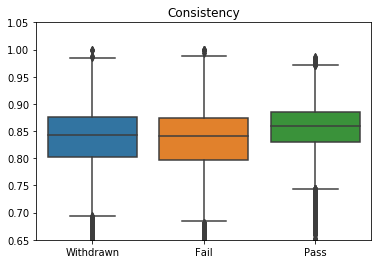

In [87]:
plt.ylim(0.65, 1.05)
ax = sns.boxplot(x='group', y='consistency', 
            data=df, order=['Withdrawn', 'Fail', 'Pass'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Consistency')

Text(0.5,1,u'Concentration')

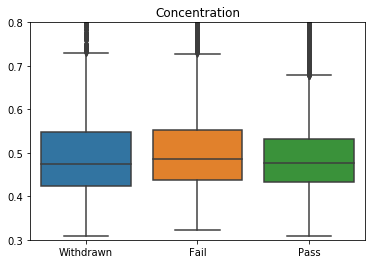

In [97]:
plt.ylim(0.3, .8)
ax = sns.boxplot(x='group', y='concentration', 
            data=df, order=['Withdrawn', 'Fail', 'Pass'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Concentration')

Text(0.5,1,u'Procastination')

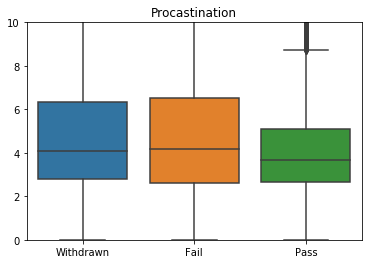

In [113]:
#plt.ylim(0.3, .8)
plt.ylim(0, 10)
ax = sns.boxplot(x='group', y='proc2', 
            data=df, order=['Withdrawn', 'Fail', 'Pass'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Procastination')

Text(0.5,1,u'Procastination')

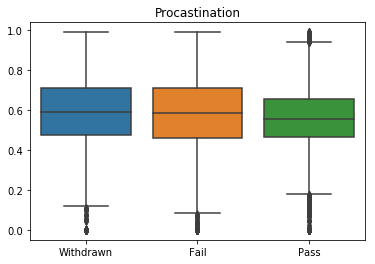

In [115]:
ax = sns.boxplot(x='group', y='proc3', 
            data=df, order=['Withdrawn', 'Fail', 'Pass'])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Procastination')

In [110]:
metrics = ['pwd', 'ws1', 'ws2', 'ws3', 'fwd', 'concentration', 'consistency', 'proc1', 'proc2', 'proc3']
group = ['Withdrawn', 'Fail', 'Pass']

for metric in metrics:
    arrs = []
    for g in group:
        mask = (df['group'] == g) & (pd.notnull(df[metric]))
        arrs.append(df[mask][metric].tolist())
    statistic, p = stats.f_oneway(*arrs)
    print('one way anova for {} is, with statistics = {} and p-value = {}'.
         format(metric, statistic, p))

one way anova for pwd is, with statistics = 96.6093696427 and p-value = 2.01315617518e-42
one way anova for ws1 is, with statistics = 321.829968842 and p-value = 1.06387778057e-137
one way anova for ws2 is, with statistics = 128.551690065 and p-value = 4.56071401473e-56
one way anova for ws3 is, with statistics = 107.580939552 and p-value = 3.94666754455e-47
one way anova for fwd is, with statistics = 42.5747936552 and p-value = 3.63150026711e-19
one way anova for concentration is, with statistics = 56.0325233186 and p-value = 5.57059244836e-25
one way anova for consistency is, with statistics = 370.44143799 and p-value = 3.66105487453e-158
one way anova for proc1 is, with statistics = 40.9522903573 and p-value = 1.81011770045e-18
one way anova for proc2 is, with statistics = 104.733584566 and p-value = 6.23757334022e-46
one way anova for proc3 is, with statistics = 30.2507243985 and p-value = 7.68764253596e-14
